In [29]:
import itertools

def build_vocab(k=6):
    base_tokens = ['A', 'T', 'G', 'C']
    vocab = ['______']

    # Generate sequences of length ℓ and pad to k
    for length in range(1, k+1):
        for comb in itertools.product(base_tokens, repeat=length):
            seq = ''.join(comb) + '_' * (k - length)
            vocab.append(seq)

    vocab2id = {v: i for i, v in enumerate(vocab)}
    id2vocab = {i: v for v, i in vocab2id.items()}
    return vocab, vocab2id, id2vocab

# Example: k=5
vocab, vocab2id, id2vocab = build_vocab(k=6)

print(f"Vocab size = {len(vocab)}")
print("Sample tokens:", vocab[:10], "...")
print("Last token:", vocab[-1])

Vocab size = 5461
Sample tokens: ['______', 'A_____', 'T_____', 'G_____', 'C_____', 'AA____', 'AT____', 'AG____', 'AC____', 'TA____'] ...
Last token: CCCCCC


In [30]:
print(vocab2id)  # Display the vocab2id dictionary to verify

{'______': 0, 'A_____': 1, 'T_____': 2, 'G_____': 3, 'C_____': 4, 'AA____': 5, 'AT____': 6, 'AG____': 7, 'AC____': 8, 'TA____': 9, 'TT____': 10, 'TG____': 11, 'TC____': 12, 'GA____': 13, 'GT____': 14, 'GG____': 15, 'GC____': 16, 'CA____': 17, 'CT____': 18, 'CG____': 19, 'CC____': 20, 'AAA___': 21, 'AAT___': 22, 'AAG___': 23, 'AAC___': 24, 'ATA___': 25, 'ATT___': 26, 'ATG___': 27, 'ATC___': 28, 'AGA___': 29, 'AGT___': 30, 'AGG___': 31, 'AGC___': 32, 'ACA___': 33, 'ACT___': 34, 'ACG___': 35, 'ACC___': 36, 'TAA___': 37, 'TAT___': 38, 'TAG___': 39, 'TAC___': 40, 'TTA___': 41, 'TTT___': 42, 'TTG___': 43, 'TTC___': 44, 'TGA___': 45, 'TGT___': 46, 'TGG___': 47, 'TGC___': 48, 'TCA___': 49, 'TCT___': 50, 'TCG___': 51, 'TCC___': 52, 'GAA___': 53, 'GAT___': 54, 'GAG___': 55, 'GAC___': 56, 'GTA___': 57, 'GTT___': 58, 'GTG___': 59, 'GTC___': 60, 'GGA___': 61, 'GGT___': 62, 'GGG___': 63, 'GGC___': 64, 'GCA___': 65, 'GCT___': 66, 'GCG___': 67, 'GCC___': 68, 'CAA___': 69, 'CAT___': 70, 'CAG___': 71, '

In [31]:
# len(vocab2id)

In [32]:
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.optim as optim
# import sklearn
from sklearn.metrics import f1_score

In [33]:
print(torch.cuda.is_available())  # Should return True
print(torch.cuda.get_device_name(0))

True
NVIDIA GeForce GTX 1650


In [ ]:
# with open('vocab6.json', 'w') as f:
#     json.dump(vocab2id, f)

# with open('vocab7.json', 'w') as f:
#     json.dump(id2vocab, f)

In [35]:
with open('vocab6.json', 'r') as f:
    vocab2id = json.load(f)

with open('vocab7.json', 'r') as f:
    id2vocab = json.load(f)

In [36]:
i = 0

In [37]:
# import torch
# import torch.nn as nn
# from torch.nn.utils.rnn import pad_sequence
# from tqdm import tqdm

# # -------------------------
# # 1. K-mer generator
# # -------------------------
# def get_k_mers(seq, k=5):
#     """Generate all possible k-mers from the given characters."""
#     return [seq[i:i+k] for i in range(len(seq) - k + 1)] if len(seq) >= k else []

# # -------------------------
# # 2. Encoding
# # -------------------------
# def encode_seq(sequence, vocab, k=5):
#     """Convert sequence into list of vocab indices via k-mers."""
#     sequence_encoded = []
#     for seq in tqdm(sequence, desc="Encoding sequences"):
#         kmers = get_k_mers(seq, k)
#         encoded_seq_dna = [vocab[kmer] for kmer in kmers if kmer in vocab]
#         sequence_encoded.append(encoded_seq_dna)
#     return sequence_encoded

# # -------------------------
# # 3. Padding at string level
# # -------------------------
# def pad_sequences_with_symbol(sequences, max_len, pad_symbol="_"):
#     """Pad DNA sequences with '_' at the END to reach max_len."""
#     return [seq + pad_symbol * (max_len - len(seq)) for seq in sequences]

# # -------------------------
# # 4. Embedding wrapper
# # -------------------------
# def embed(vocab, embed_dim=64, encoded=list()):
#     """Convert list of encoded k-mers → padded tensor → embeddings."""
#     # Create embedding layer (with padding_idx = 0!)
#     embedding = nn.Embedding(len(vocab) + 1, embed_dim, padding_idx=0)

#     # Convert each sequence into torch tensor
#     encoded_tensor = [torch.tensor(seq, dtype=torch.long) for seq in encoded]

#     # Pad sequences with 0 (since padding_idx=0)
#     padded_tensor = pad_sequence(encoded_tensor, batch_first=True, padding_value=0)

#     # Apply embedding
#     vec = embedding(padded_tensor)

#     print(f"Encoded tensor shape: {padded_tensor.shape}")  # (batch, seq_len)
#     print(f"Embedding shape: {vec.shape}")                # (batch, seq_len, embed_dim)

#     return padded_tensor, vec

# # -------------------------
# # 5. Example pipeline
# # -------------------------
# train_seqs = ["ACTGACT", "CTGA", "TTACTG"]
# test_seqs  = ["ACGT", "TTT"]

# # 1. Find max length across train + test
# max_len = max(
#     max(len(s) for s in train_seqs),
#     max(len(s) for s in test_seqs)
# )

# # 2. Pad sequences with "_" at END
# train_padded = pad_sequences_with_symbol(train_seqs, max_len)
# test_padded  = pad_sequences_with_symbol(test_seqs, max_len)

# print("Train padded:", train_padded)
# print("Test padded:", test_padded)

# # 3. Build vocab (example: all possible k-mers)
# k = 3
# all_kmers = set()
# for seq in train_padded + test_padded:
#     all_kmers.update(get_k_mers(seq, k))
# vocab = {kmer: i+1 for i, kmer in enumerate(sorted(all_kmers))}  # +1 since 0 is padding

# # 4. Encode sequences
# train_encoded = encode_seq(train_padded, vocab, k=k)
# test_encoded  = encode_seq(test_padded, vocab, k=k)

# # 5. Embed
# train_encoded_tensor, train_vec = embed(vocab, embed_dim=64, encoded=train_encoded)
# test_encoded_tensor, test_vec   = embed(vocab, embed_dim=64, encoded=test_encoded)


In [38]:
vocab = vocab2id

In [39]:
dirs = ["human_nontata_promoters", "drosophila_enhancers_stark", "human_enhancers_ensembl"]
path = os.path.join(os.getcwd(), "data", dirs[i], dirs[i]) # change index to change dataset

train_df = pd.read_csv(os.path.join(path, "train", f"{dirs[i]+'_train.csv'}"))
test_df = pd.read_csv(os.path.join(path, "test", f"{dirs[i]+'_train.csv'}"))
print(f"Train shape: {train_df.shape}, Test shape: {test_df.shape}")

# if train_df.shape[0] > 3000:
#     train_df = train_df.sample(n=3000, random_state=42).reset_index(drop=True)

# if test_df.shape[0] > 1500:
#     test_df = test_df.sample(n=1500, random_state=42).reset_index(drop=True)

Train shape: (27097, 2), Test shape: (9034, 2)


In [40]:
def get_k_mers(seq, k=6):
    """Generate all possible k-mers from the given characters."""
    return [seq[i:i+k] for i in range(len(seq)-k+1)]

def encode_seq(sequence, vocab, k = 6, max_len=None):
    sequence_encoded = []
    for seq in tqdm(sequence, desc="Encoding sequences"):
        kmers = get_k_mers(seq, k)
        encoded_seq_dna = [vocab[k] for k in kmers if k in vocab]
        sequence_encoded.append(encoded_seq_dna)

    if max_len is None:
        max_len = max(len(x) for x in sequence_encoded)
    sequence_encoded = pad_sequences(sequence_encoded, maxlen=max_len, padding='post', value=0)        
    return sequence_encoded

In [41]:
def pad_sequences_with_symbol(sequences, max_len, pad_symbol="_"):
    """Pad DNA sequences with '_' only at the end to reach max_len."""
    return [seq + pad_symbol * (max_len - len(seq)) for seq in sequences]

In [42]:
# 1. Find max length across train + test
max_len = max(
    max(train_df['DNA_seq'].str.len()), 
    max(test_df['DNA_seq'].str.len())
)

print(max_len)

251


In [43]:
train_df['DNA_seq'].values

array(['TCGGCCTGCGGACTCTTCCGGCCCGAACTTCTCTTACCTACCCCGCGCTCCCCGGTGCAGCCGGGCTGTGGAAGGCTTGCAGGGGAGGAAGCTAAAAAGTTTGCACAGGGCAACTCCCGCCCTTGCTCCCTCGGGACTCTCCGTGGAGCTCCCACGGACTGAAAGAGCGTGCCCCCCAACCCGAACGAGCCCCGCCGGGGCCTTTGCAAAGGGCAGCAGTGGCCGTCGCTGCCCGTGCGGCTCCCGTGGCT',
       'GTGGCTGGCAGCCTGTGGCAGGGGCACTCTCGGGACTTCTCACGGGACGCCCGGTCCTTGGGCGTGCAGGGGTCATGGGGGGTGACGGGGCCGCGGGAGCGCCGGGTTTTCGTAGAGCCCAGGTGCGCGGTGGTGCTTGCATTCGAGAGGGAGGGGCGTGGTACCGGACGAGGGGGGCGGCGATGGCCCCGAGGGCACCGGGGCTGACGGGACCCCTCGCCCTTGCCCGCGTGTAGGATGGATAAGGTGGG',
       'CAGACTCAGAAAAAGCTCAATAATTTTCCACAAGTCACACAGCTATTAGAAAGATAGGGAACTAGAATGATCCCACATCTCTCTGGCTTTACTCTGGTACATTGAGATAAGCTGTTCTCTGTCTTGCTTTTTACATTTGGAGCACTGGTCTCTCCAAGGGGAACAAGAGCAGGAAGTAGGTAGATATTCTATAAGCCAAATCTGATATTTCCAATGGTGTTTCCTCTTACTAGAATCGTATGCATGAGTCT',
       ...,
       'ATTATTCTTGTCTGCTTTCTCCCTCCTTTAGGTTGCATTGGAGTTTTCGAAAGACTTATCTTTCTGCAGGCTCGCCTCTGAGCTTTGTCTCCTTGGAGCCACCTCACTTAGACAGCTTCGGATGTGGATGCAGATTTGAACCATGTTGCGTCCCCAGGGACTGCTATGGCTCCCTTTGTTGTTCACCTCTGTCT

In [44]:
# 2. Pad sequences BEFORE k-mer encoding
train_padded_seqs = pad_sequences_with_symbol(train_df['DNA_seq'].values, max_len)
test_padded_seqs  = pad_sequences_with_symbol(test_df['DNA_seq'].values, max_len)

In [45]:
for i in range(5):
    print(len(train_padded_seqs[:10][i]))

251
251
251
251
251


In [46]:


# 3. Encode using your existing pipeline
train_encoded = encode_seq(train_padded_seqs, vocab, k=6)
test_encoded  = encode_seq(test_padded_seqs, vocab, k=6)

# 4. Embedding step (no need for pad_sequence here, already uniform length)


Encoding sequences: 100%|██████████| 9034/9034 [00:00<00:00, 22627.65it/s]


In [47]:
for i in range(5):
    print(len(train_encoded[:10][i]))

for i in range(5):
    print(len(test_encoded[:10][i]))

246
246
246
246
246
246
246
246
246
246


In [48]:
dim = 16

def embed(vocab, embed_dim=32, encoded=list()):
    embedding = nn.Embedding(len(vocab), embed_dim)
    encoded_tensor = torch.tensor(encoded, dtype=torch.long)
    # padded_tensor = pad_sequence(encoded_tensor, batch_first=True, padding_value='0') 
    lengths = [len(seq) for seq in encoded]
    assert len(set(lengths)) == 1, f"Sequences not uniform, got lengths: {set(lengths)}" 
    vec = embedding(encoded_tensor)
    print(encoded_tensor.shape, vec.shape)
    return encoded_tensor, vec

train_encoded_tensor, train_vec = embed(vocab, embed_dim=dim, encoded=train_encoded)
test_encoded_tensor, test_vec   = embed(vocab, embed_dim=dim, encoded=test_encoded)


torch.Size([27097, 246]) torch.Size([27097, 246, 16])
torch.Size([9034, 246]) torch.Size([9034, 246, 16])


In [49]:
train_padded = pad_sequence(train_encoded_tensor, batch_first=True, padding_value=0)
print(train_padded.shape)
test_padded = pad_sequence(test_encoded_tensor, batch_first=True, padding_value=0)
print(test_padded.shape)
# X_train = train_padded  # Already tensor

torch.Size([27097, 246])
torch.Size([9034, 246])


In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [51]:
class Model(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes, hidden_dim=128, num_filters=64, kernel_size=7):
        super(Model, self).__init__()
        
        # Embedding for k-mers
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        
        # 1D Convolution (motif extraction)
        self.conv1 = nn.Conv1d(embed_dim, num_filters, kernel_size, padding=kernel_size//2)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(2)  # reduce sequence length by half
        
        # GRU for sequential dependency
        self.gru = nn.GRU(input_size=num_filters, hidden_size=hidden_dim, batch_first=True, bidirectional=True)
        
        # Final classifier
        self.fc = nn.Linear(hidden_dim * 2, num_classes)  # *2 because bidirectional
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        # x: (batch_size, seq_len)
        x = self.embedding(x)               # (batch, seq_len, embed_dim)
        x = x.permute(0, 2, 1)             # (batch, embed_dim, seq_len) for Conv1d
        x = self.conv1(x)                  # (batch, num_filters, seq_len)
        x = self.relu(x)
        x = self.pool(x)                   # (batch, num_filters, seq_len/2)

        x = x.permute(0, 2, 1)             # (batch, seq_len/2, num_filters) for GRU
        out, _ = self.gru(x)               # (batch, seq_len/2, hidden_dim*2)

        # Take the last time-step output
        out = out[:, -1, :]                # (batch, hidden_dim*2)
        out = self.dropout(out)
        out = self.fc(out)                 # (batch, num_classes)
        return out

In [52]:
X_train = train_padded
y_train = torch.tensor(train_df['label'].astype('category').cat.codes.values, dtype=torch.long)  # Convert labels to categorical codes
X_test = test_padded
y_test = torch.tensor(test_df['label'].astype('category').cat.codes.values, dtype=torch.long)  # Convert labels to categorical codes

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([27097, 246]) torch.Size([27097])
torch.Size([9034, 246]) torch.Size([9034])


In [53]:
batch_size = 32

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [60]:
epochs = 20                  # set higher, early stopping will cut it short
learning_rate = 0.001
patience = 4                # stop if val loss doesn’t improve for 5 epochs
best_val_loss = np.inf
patience_counter = 0

num_classes = len(torch.unique(y_train))
model = Model(vocab_size=len(vocab), embed_dim=64, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

# --- Lists for tracking ---
train_loss_list, val_loss_list = [], []
train_acc_list, val_acc_list = [], []
train_f1_list, val_f1_list = [], []



for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0
    train_true, train_pred = [], []

    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()
        train_true.extend(batch_y.cpu().numpy())
        train_pred.extend(predicted.cpu().numpy())

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    train_f1 = f1_score(train_true, train_pred, average='macro')

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    val_true, val_pred = [], []
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += batch_y.size(0)
            val_correct += (predicted == batch_y).sum().item()
            val_true.extend(batch_y.cpu().numpy())
            val_pred.extend(predicted.cpu().numpy())

    val_loss /= len(test_loader)
    val_acc = val_correct / val_total
    val_f1 = f1_score(val_true, val_pred, average='macro')

    # Save for plotting later
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    train_acc_list.append(train_accuracy)
    val_acc_list.append(val_acc)
    train_f1_list.append(train_f1)
    val_f1_list.append(val_f1)

    # Learning rate scheduler
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{epochs}, "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Train F1: {train_f1:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}")

    # ---- Early Stopping ----
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = model.state_dict()  # save best model
    else:
        patience_counter += 1
        print(f"Patience counter: {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("Early stopping triggered ✅")
            break

# Load best model weights after stopping
model.load_state_dict(best_model_state)

Epoch 1/20, Train Loss: 0.4597, Train Acc: 0.7692, Train F1: 0.7683, Val Loss: 0.3458, Val Acc: 0.8555, Val F1: 0.8555
Epoch 2/20, Train Loss: 0.2692, Train Acc: 0.8936, Train F1: 0.8934, Val Loss: 0.2419, Val Acc: 0.9068, Val F1: 0.9067
Epoch 3/20, Train Loss: 0.1470, Train Acc: 0.9479, Train F1: 0.9477, Val Loss: 0.2267, Val Acc: 0.9220, Val F1: 0.9217
Epoch 4/20, Train Loss: 0.0765, Train Acc: 0.9743, Train F1: 0.9741, Val Loss: 0.2868, Val Acc: 0.9151, Val F1: 0.9151
Patience counter: 1/4
Epoch 5/20, Train Loss: 0.0421, Train Acc: 0.9861, Train F1: 0.9860, Val Loss: 0.2150, Val Acc: 0.9342, Val F1: 0.9341
Epoch 6/20, Train Loss: 0.0275, Train Acc: 0.9905, Train F1: 0.9904, Val Loss: 0.3061, Val Acc: 0.9397, Val F1: 0.9394
Patience counter: 1/4
Epoch 7/20, Train Loss: 0.0246, Train Acc: 0.9916, Train F1: 0.9915, Val Loss: 0.3546, Val Acc: 0.9286, Val F1: 0.9285
Patience counter: 2/4
Epoch 8/20, Train Loss: 0.0176, Train Acc: 0.9943, Train F1: 0.9943, Val Loss: 0.3943, Val Acc: 0.920

<All keys matched successfully>

In [61]:
i = 0

In [62]:
dirs = ["human_nontata_promoters", "drosophila_enhancers_stark", "human_enhancers_ensembl"]

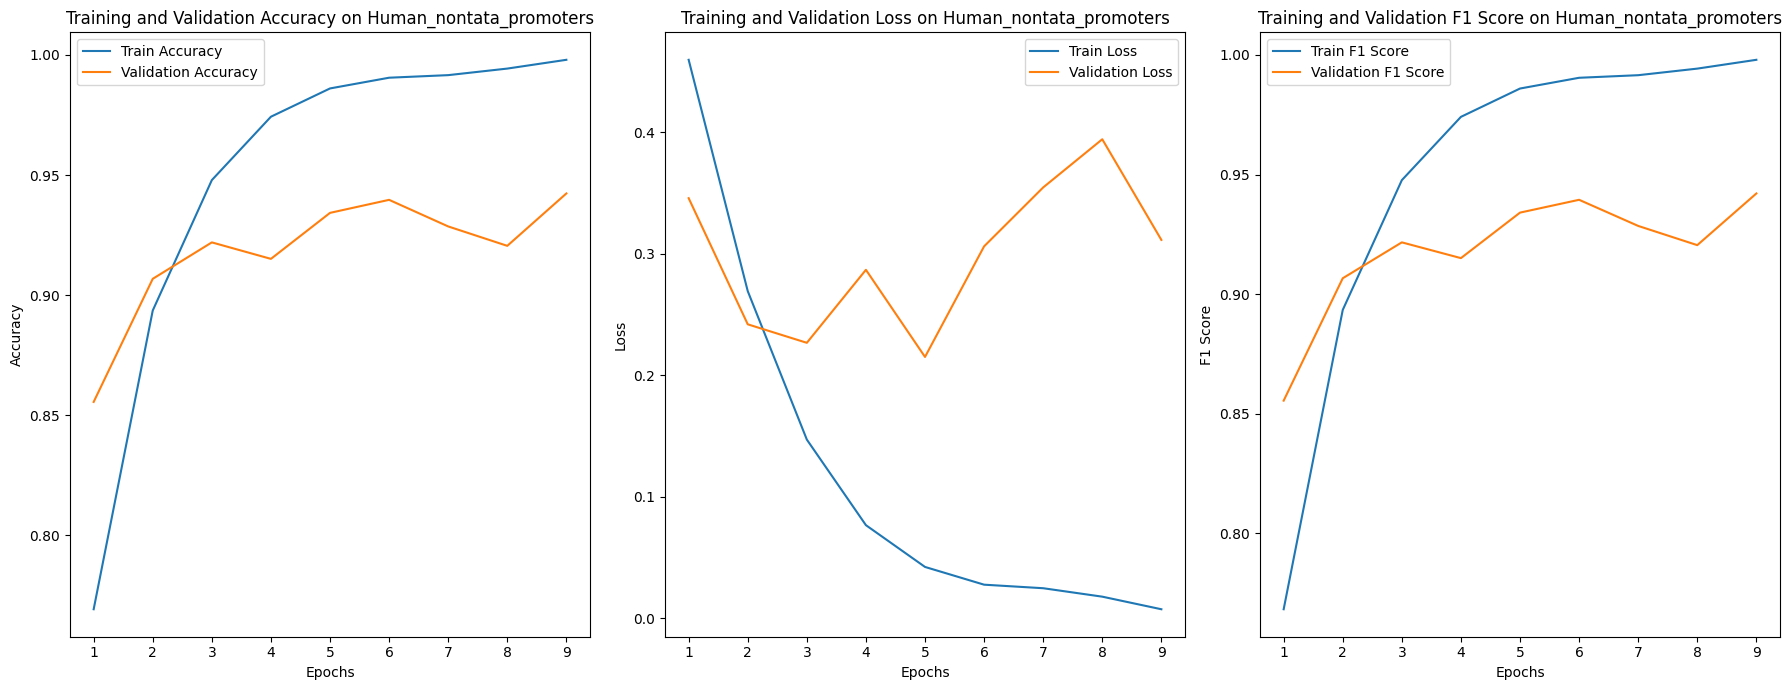

In [63]:
import matplotlib.pyplot as plt
epochs_range = range(1, len(train_acc_list) + 1)

# Create subplots: 1 row, 2 columns
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 7))

# Plot Accuracy
ax1.plot(epochs_range, train_acc_list, label='Train Accuracy')
ax1.plot(epochs_range, val_acc_list, label='Validation Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.set_title(f'Training and Validation Accuracy on {dirs[0].capitalize()}')
ax1.legend()

# Plot Loss
ax2.plot(epochs_range, train_loss_list, label='Train Loss')
ax2.plot(epochs_range, val_loss_list, label='Validation Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_title(f'Training and Validation Loss on {dirs[0].capitalize()}')
ax2.legend()

ax3.plot(epochs_range, train_f1_list, label='Train F1 Score')
ax3.plot(epochs_range, val_f1_list, label='Validation F1 Score')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('F1 Score')
ax3.set_title(f'Training and Validation F1 Score on {dirs[0].capitalize()}')
ax3.legend()

plt.tight_layout()
plt.show()